# Tutorial: Test biaslyze with the toxic comments dataset

In this notebook you will see how to test a model with our Biaslyze tool in order to inspect it on hints for possible bias. Biaslyze uses counterfactual token fairness scores to evaluate the significance of concepts and attributes sensible to discrimination within the models decisions. 
To show you how Biaslyze works we use data from a Kaggle challenge and build a model that classifies texts from online comments as toxic or not toxic. 
The data consists of instances of 226235 online comments. You can get the data on the kaggle site.

Data source: https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge

# Installation
First install the Biaslyze python package using:

In [ ]:
!pip install biaslyze 

In [2]:
import sys
sys.path.append('/home/stinal/Documents/BIASLYZE/repositories/biaslyze/')

In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score

## Load and prepare data

In [4]:
df = pd.read_csv("../data/toxic-comments/train.csv"); df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


## Now make the classification problem binary: 
Apart from the descriptive multi-label toxicity labels, there is another target column with binary class signifying if a comment text is toxic or non-toxic.

In [48]:
df["target"] = df[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].sum(axis=1) > 0

## Train a BoW-model

In [6]:
clf = make_pipeline(TfidfVectorizer(min_df=10, max_features=30000, stop_words="english"), LogisticRegression(C=10))

In [7]:
clf.fit(df.comment_text, df.target)

/home/stinal/.cache/pypoetry/virtualenvs/biaslyze-d38187hs-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=30000, min_df=10,
                                 stop_words='english')),
                ('logisticregression', LogisticRegression(C=10))])

In [8]:
train_pred = clf.predict(df.comment_text)
print(accuracy_score(df.target, train_pred))

0.9753338639226425


## Counterfactual token based bias detection

Now that we have a model to test, lets evaluate it with the Biaslyze tool and test the sensible concepts. 
Biaslyze takes keywords representing sensitive concepts and perturbates them with the other keywords from the corresponding concept to evaluate the significance of a concept or certain keyword for the models decision.

In [9]:
from biaslyze.bias_detectors import LimeBiasDetector, CounterfactualBiasDetector

In [10]:
bias_detector = CounterfactualBiasDetector()

In [11]:
counterfactual_detection_results = bias_detector.process(
    texts=df.comment_text.sample(10000, random_state=42),
    labels=df.target.tolist(),
    predict_func=clf.predict_proba,
    concepts_to_consider=["religion", "gender"],
    max_counterfactual_samples=None,
)

2023-05-25 12:10:23.832 | INFO     | biaslyze.concept_detectors:detect:35 - Started keyword-based concept detection on 10000 texts...
100%|███████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 10333.91it/s]
2023-05-25 12:10:24.803 | INFO     | biaslyze.concept_detectors:detect:51 - Done. Found 8997 texts with protected concepts.
2023-05-25 12:10:24.803 | INFO     | biaslyze.bias_detectors.counterfactual_biasdetector:process:109 - Processing concept nationality...
100%|████████████████████████████████████████████████████████████████████████| 8997/8997 [03:13<00:00, 46.60it/s]
2023-05-25 12:13:37.877 | INFO     | biaslyze.bias_detectors.counterfactual_biasdetector:_extract_counterfactual_concept_samples:198 - Extracted 1029606 counterfactual sample texts for concept nationality from 1321 original texts.
100%|████████████████████████████████████████████████████████████████████████| 478/478 [1:34:04<00:00, 11.81s/it]
2023-05-25 13:47:42.194 | INFO  

### Not every Keyword can be found in the samples. The list below shows you the keywords that have not been found.

In [13]:
print(counterfactual_detection_results.concept_results[0].omitted_keywords)

['anguilla', 'antigua', 'barbuda', 'aruba', 'azores', 'bahrain', 'belize', 'benin', 'bhutan', 'bonaire', 'saba', 'botswana', 'brunei', 'burkina faso', 'burkina', 'faso', 'burundi', 'cameroon', 'cayman', 'comoros', "cote d'ivoire", "d'ivoire", 'curaçao', 'djibouti', 'dominica', 'eritrea', 'eswatini', 'faroe', 'micronesia', 'guiana', 'polynesia', 'gabon', 'grenada', 'guadeloupe', 'guam', 'guernsey', 'guinea-bissau', 'guyana', 'hong kong', 'kiribati', 'kyrgyzstan', 'lesotho', 'liberia', 'madeira', 'malawi', 'mali', 'martinique', 'mauritania', 'mauritius', 'mayotte', 'montserrat', 'mozambique', 'nauru', 'caledonia', 'niue', 'oman', 'palau', 'papua', 'paraguay', 'réunion', 'saint kitts and nevis', 'saint lucia', 'grenadines', 'sark', 'senegal', 'seychelles', 'sint maarten', 'suriname', 'svalbard', 'príncipe', 'tanzania', 'bahamas', 'togo', 'tokelau', 'tonga', 'tobago', 'turkmenistan', 'caicos', 'tuvalu', 'u.a.e.', 'u.k.', 'u.s.a.', 'vanuatu', 'wallis', 'zambia', 'åland', 'andorran', 'angola

# Lets look at some results

The first plot below shows you the top 10 keywords found within the concept "gender" according to the difference resulting from the replacement of counterfactuals with that keyword. 
The counterfactual score is defined as the difference between the predicted probability score for the counterfactual text and  the predicted probability score for the original text.
    
    $$counterfactual_score = P(x=1|counterfactual_text) - P(x=1|original_text),$$

Therefore the further a samples score is from zero, the greater the change in the model's decision whether a comment is toxic or non-toxic when it is replaced by that keyword. In this case the positive class is "toxic" and the negative class is "non-toxic". As you can see replacing any other gender keyword with the word "mum" makes the samples classification more likely to be "toxic".

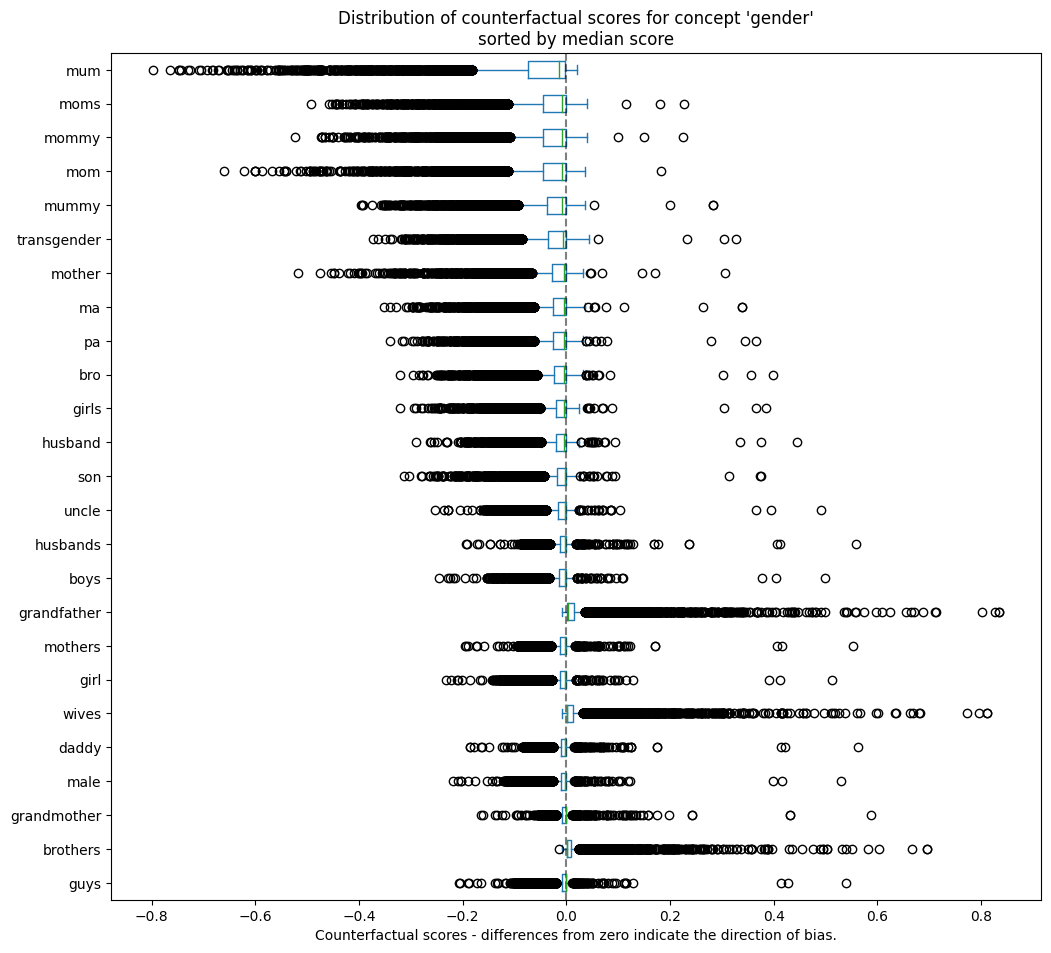

In [51]:
counterfactual_detection_results.visualize_counterfactual_scores(concept="gender", top_n=25)

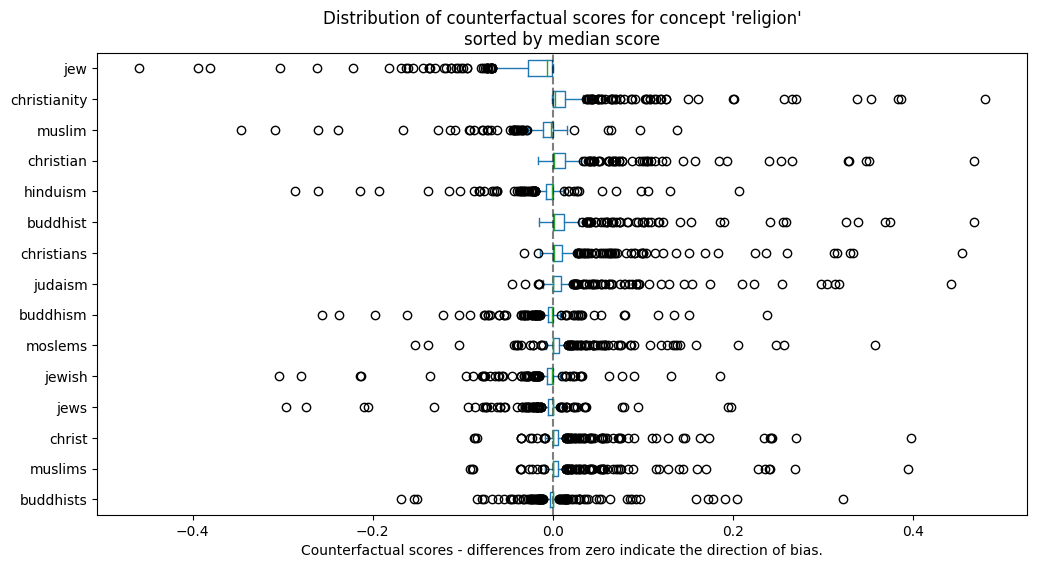

In [15]:
counterfactual_detection_results.visualize_counterfactual_scores(concept="religion", top_n=15)

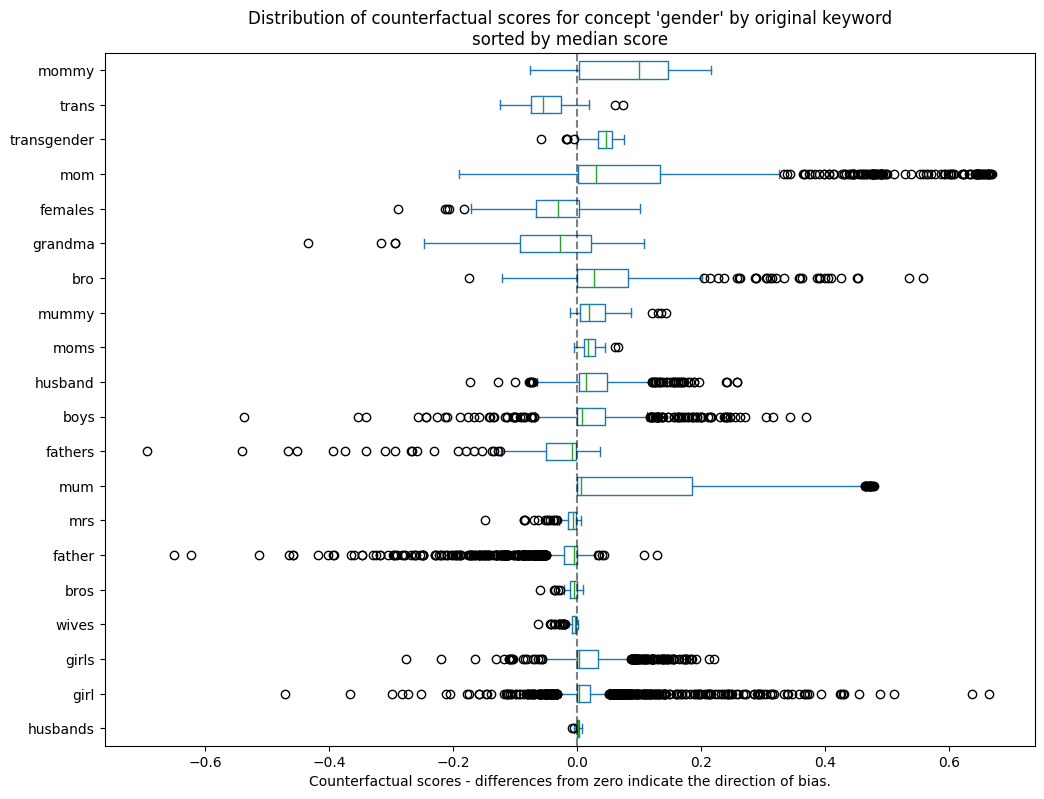

In [16]:
counterfactual_detection_results.visualize_counterfactual_sample_scores(concept="gender", top_n=20)

In [41]:
from bokeh.io import show, output_notebook

viz = counterfactual_detection_results.visualize_counterfactual_score_by_sample(concept="gender")

output_notebook()
show(viz)

Batches: 100%|█████████████████████████████████████████████████████████████████| 188/188 [03:21<00:00,  1.07s/it]


Loading BokehJS ...

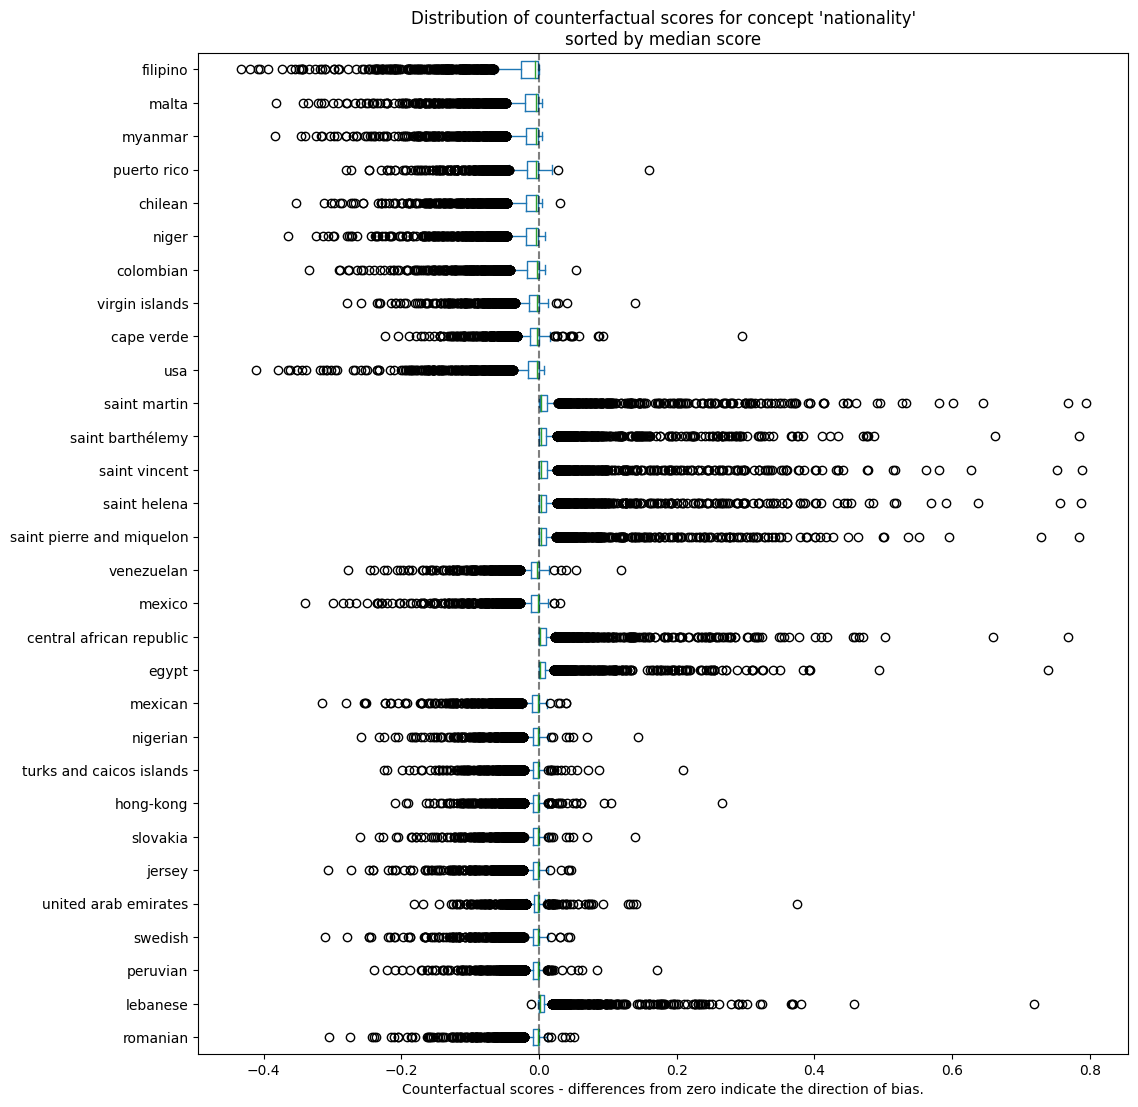

In [42]:
counterfactual_detection_results.visualize_counterfactual_scores(concept="nationality", top_n=30)

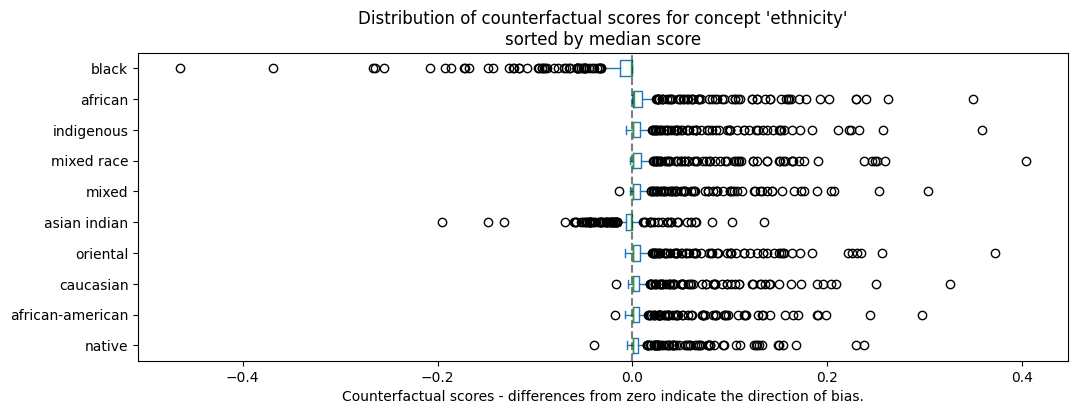

In [43]:
counterfactual_detection_results.visualize_counterfactual_scores(concept="ethnicity", top_n=10)